# Отчет по модулю В

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import sqlite3

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, MiniBatchKMeans, Birch
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

## Импорт данных

In [2]:
# Берем данные из базы, которую создали в прошлом модуле.

con = sqlite3.connect('../data/db.db')
sql = 'select * from metro'
# Отбираем только значимые отрибуты, которые получили в прошлом модуле.
df = pd.read_sql(sql, con)[['date', 'line', 'trip', 'hour', 'num_val', 'output_escalator_count', 'output_doors_count',
                            'output_turnstile_count', 'input_turnstile_total_bandwidth',
                            'input_turnstile_count', 'input_doors_count', 'entry_id']]
df.head(3)

,date,line,trip,hour,num_val,output_escalator_count,output_doors_count,output_turnstile_count,input_turnstile_total_bandwidth,input_turnstile_count,input_doors_count,entry_id
0,2023-01-26,СОКОЛЬНИЧЕСКАЯ,Б.Рокоссовского - Б.Рокоссовского,15.0,433.0,0.0,4.0,5.0,8.0,8.0,4.0,1.0
1,2023-02-15,ТАГАНСК-КРАСНОПР,Сходненская - Сходненская,4.0,1.0,0.0,4.0,0.0,8.0,8.0,4.0,12.0
2,2023-05-09,БКЛ,Каховская - Каховская,11.0,277.0,0.0,4.0,0.0,8.0,8.0,4.0,1.0


# 2.1 Построение аналитической системы

Выполнение задания представлено в каталоге dashboard в корне проекта


# 2.2 Кластеризация набора данных

Рассмотрим 3 метода кластеризации:
- **KMeans** - этот алгоритм является неиерархическим, итерационным методом кластеризации, он получил большую популярность благодаря своей простоте, наглядности реализации и достаточно высокому качеству работы.
-  **MiniBatchKMeans** - является самым простым и самым быстрым, но в тоже время и неточным алгоритмом кластеризации, для его использования необходимо всегда знать количество кластеров, основная идея которого это использование небольших случайных партий фиксированного размера.
-  **AgglomerativeClustering** – это один из алгоритмов кластеризации, в котором процесс группировки похожих экземпляров начинается с создания нескольких групп, где каждая группа содержит один объект на начальном этапе, затем он находит две наиболее похожие группы, объединяет их, повторяет процесс до тех пор, пока не получит единую группу наиболее похожих экземпляров. 

Задача кластеризации – сегментация поездок, определение схожих групп объектов в каждом наборе данных. 

Будем определять 3 кластера:
- в первый кластер попадают все маршруты, для которых поездка в заданное время оптимальна
- во второй кластер попадают маршруты с нежелательным временем поездки
- в третий кластер попадают маршруты, от поездок по которым следует воздержаться в заданный период времени

Лучшей практикой для оценки качества кластеризации служат метрики:
- **Индекс Дэвиса-Болдина.** Этот индекс обозначает среднее «сходство» между кла- стерами, где сходство – это мера, которая сравнивает расстояние между кластерами с разме- ром самих кластеров. Более низкий индекс Дэвиса-Болдина относится к модели с лучшим разделением кластеров.
- **Индекс Calinski–Harabasz.** Компактность основана на расстоянии от точек кластера до их центроидов, а разделимость - на расстоянии от центроид кластеров до глобального центроида. Должен возрастать.
- **Силуэт (англ. Silhouette).** Значение силуэта показывает, насколько объект похож на свой кластер по сравнению с другими кластерами. Чем ближе данная оценка к 1, тем лучше.


## Предобработка данных

Проведем предобработку данных для лучшей работы алоритмов.

In [3]:
# Удаляем выбросы
df = df[df['num_val'] < 1500]

# Выделяем год-месяц-день из даты
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop(['date'], axis=1, errors='ignore')

num_features = df.describe().columns

# Масштабируем данные и исключаем пропуски для корректности кластеризации
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]
)
preprocessor.fit(df[num_features])
X = preprocessor.transform(df[num_features]).astype('float32')
X

array([[ 0.40741214, -0.04458154, -0.24408087, ...,  0.        ,
        -1.5265386 ,  1.2359614 ],
       [-1.2011089 , -1.1466442 , -0.24408087, ...,  0.        ,
        -1.0779291 , -0.03190308],
       [-0.1775046 , -0.4425486 , -0.24408087, ...,  0.        ,
         0.26789925, -0.72346556],
       ...,
       [-1.7860256 , -0.8328625 , -0.24408087, ...,  0.        ,
        -0.18071024,  1.0054406 ],
       [ 1.138558  , -0.14407331, -0.24408087, ...,  0.        ,
        -0.6293197 ,  1.8122635 ],
       [ 0.5536413 ,  0.37124303, -0.24408087, ...,  0.        ,
        -1.0779291 , -1.1845071 ]], dtype=float32)

Для визуализации работы алгоритмов представим данные в двуразмером виде с помощью метода PCA.

In [4]:
pca = PCA(n_components=2)
pca.fit(X)
data_for_visualization = pd.DataFrame(pca.transform(X), columns=['x', 'y'])

## KMeans

### Обучение

In [5]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans_labels = kmeans.predict(X)

### Метрики

In [6]:
# Индекс Дэвиса-Болдина
print(f'Индекс Дэвиса-Болдина для алгоритма: {davies_bouldin_score(X, kmeans_labels):.3f}')
# Индекс Calinski–Harabasz
print(f'Индекс Calinski–Harabasz для алгоритма: {calinski_harabasz_score(X, kmeans_labels):.3f}')
# Силуэт, для скорости расчета берем часть данных
idx = [np.random.randint(X.shape[0]) for _ in range(30000)]
print(f'Метрика Силуэт для алгоритма: {silhouette_score(X[idx], kmeans_labels[idx]):.3f}')

Индекс Дэвиса-Болдина для алгоритма: 2.406
Индекс Calinski–Harabasz для алгоритма: 2828.234
Метрика Силуэт для алгоритма: 0.102


### Визуализация

<Axes: xlabel='x', ylabel='y'>

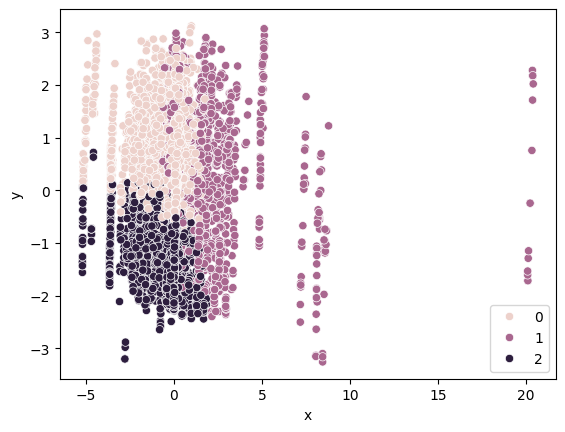

In [7]:
# Отрисовываем часть данных
idx = [np.random.randint(X.shape[0]) for _ in range(10000)]
sns.scatterplot(data=data_for_visualization.loc[idx], x='x', y='y', hue=kmeans_labels[idx])

## MiniBatchKMeans

### Обучение

In [10]:
MNkmeans = MiniBatchKMeans(n_clusters=3)
MNkmeans.fit(X)
MNkmeans_labels = MNkmeans.predict(X)

### Метрики

In [11]:
# Индекс Дэвиса-Болдина
print(f'Индекс Дэвиса-Болдина для алгоритма: {davies_bouldin_score(X, MNkmeans_labels):.3f}')
# Индекс Calinski–Harabasz
print(f'Индекс Calinski–Harabasz для алгоритма: {calinski_harabasz_score(X, MNkmeans_labels):.3f}')
# Силуэт, для скорости расчета берем часть данных
idx = [np.random.randint(X.shape[0]) for _ in range(30000)]
print(f'Метрика Силуэт для алгоритма: {silhouette_score(X[idx], MNkmeans_labels[idx]):.3f}')

Индекс Дэвиса-Болдина для алгоритма: 2.386
Индекс Calinski–Harabasz для алгоритма: 299879.151
Метрика Силуэт для алгоритма: 0.133


### Визуализация

<Axes: xlabel='x', ylabel='y'>

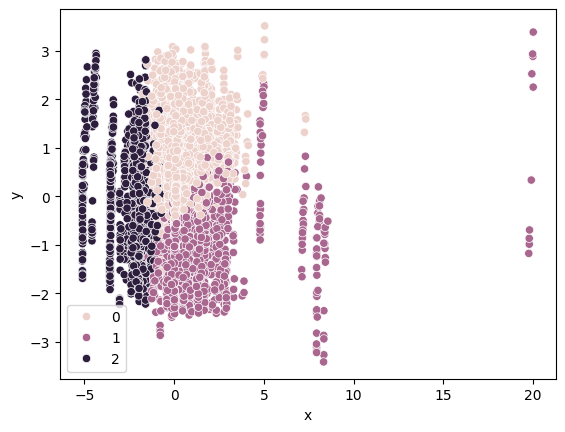

In [12]:
# Отрисовываем часть данных
idx = [np.random.randint(X.shape[0]) for _ in range(10000)]
sns.scatterplot(data=data_for_visualization.loc[idx], x='x', y='y', hue=MNkmeans_labels[idx])

## Birch

### Обучение

In [19]:
idx = [np.random.randint(X.shape[0]) for _ in range(10000)]
birch = Birch(n_clusters=3)
birch.fit(X[idx])
birch_labels = birch.predict(X[idx])

### Метрики

In [21]:
# Индекс Дэвиса-Болдина
print(f'Индекс Дэвиса-Болдина для алгоритма: {davies_bouldin_score(X[idx], birch_labels):.3f}')
# Индекс Calinski–Harabasz
print(f'Индекс Calinski–Harabasz для алгоритма: {calinski_harabasz_score(X[idx], birch_labels):.3f}')
# Силуэт
print(f'Метрика Силуэт для алгоритма: {silhouette_score(X[idx], birch_labels):.3f}')

Индекс Дэвиса-Болдина для алгоритма: 1.208
Индекс Calinski–Harabasz для алгоритма: 936.060
Метрика Силуэт для алгоритма: 0.320


### Визуализация

<Axes: xlabel='x', ylabel='y'>

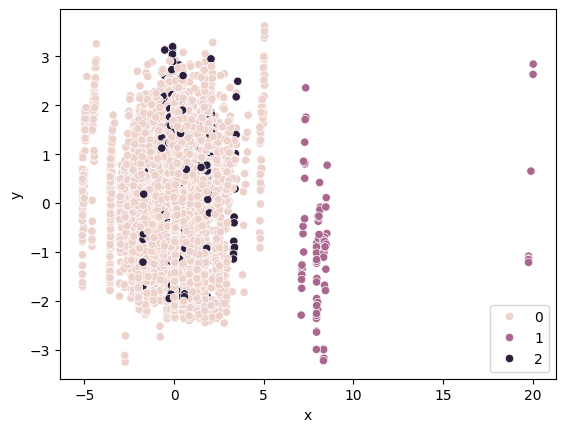

In [22]:
# Отрисовываем часть данных
sns.scatterplot(data=data_for_visualization.loc[idx], x='x', y='y', hue=birch_labels)

# Вывод
На основе выбранной метрики лучшим алгоритмом кластеризации стал KMeans. Визуально он также отлично справился с кластеризацией. 

Будем использовать его разделение для последующего анализа.

In [8]:
df['cluster'] = kmeans_labels

## Описание кластеров

Определим и поименнуем получившиеся кластеры:
1. Поездка в утренее время, перед час-пиком, минимальная загруженность станции, **поездка оптимальна**
2. Поездка в дневное время, средняя загруженнность станции, **поездка нежелательна**
3. Поездка в вчернее время, час-пик, максимальная загруженность станции, от поездки **следует отказаться**

In [9]:
df.groupby('cluster')[num_features].mean()

,hour,num_val,output_escalator_count,output_doors_count,output_turnstile_count,input_turnstile_total_bandwidth,input_turnstile_count,input_doors_count,entry_id,year,month,day
cluster,,,,,,,,,,,,
0,16.166959,597.840186,0.128236,3.460566,3.720751,7.197873,7.167770,3.636865,2.572948,2023.0,4.516446,15.325357
1,13.178222,563.694800,0.197438,4.217596,4.166729,10.814996,10.814996,4.771289,7.618312,2023.0,4.369442,15.384702
2,4.875949,129.731300,0.125404,3.354943,3.569849,7.132551,7.090693,3.618853,3.249957,2023.0,4.229229,15.127963


# Отчет по модулю В

В ходе выполнения модуля B было выполнено следующее:
- Построена аналитическая система
- Набор кластер кластеризован
- подготовлен отчет

In [12]:
df.to_csv('data.csv', index=False)

con = sqlite3.connect('../data/db.db')
pd.to_sql(df, con=con, index=False, if_exists='replace')

AttributeError: module 'pandas' has no attribute 'to_sql'